In [120]:
from s04utils.modules.load import timestamps

from bokeh.plotting import figure, show, output_notebook, curdoc
from IPython.core.display import set_matplotlib_formats

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from sfHMM import sfHMM1
from pybaselines import Baseline

In [121]:
# Set the path to the data

# 'step-like' shape
timestamps_path_01 = '/Users/kappel/Messungen/Setup04/JaKa/post_hack/23_08_29/77K-33nM-eGFP-vitrified/20uW/timestamps/tt_eGFP_33nM_NaP_100mM_ph7dot5_Treh7dot5_20uW_77K_circpol_002.h5'
#timestamps_path_01 = '/Users/kappel/Messungen/Setup04/JaKa/post_hack/23_08_29/77K-33nM-eGFP-vitrified/10uW/timestamps/tt_eGFP_33nM_NaP_100mM_ph7dot5_Treh7dot5_10uW_77K_circpol_020.h5'
#timestamps_path_01 = '/Users/kappel/Messungen/Setup04/JaKa/post_hack/23_08_29/77K-33nM-eGFP-vitrified/05uW/timestamps/tt_eGFP_33nM_NaP_100mM_ph7dot5_Treh7dot5_05uW_77K_circpol_019.h5'
#timestamps_path_01 = '/Users/kappel/Messungen/Setup04/JaKa/post_hack/23_08_25/77K-33nM-eGFP-vitrified/05uW/timestamps/tt_eGFP_33nm_NaP_100mM_ph7dot5_Treh7dot5_05uW_77K_circpol_015.h5'
#timestamps_path_01 = '/Users/kappel/Messungen/Setup04/JaKa/post_hack/23_08_09/77K-33nM-eGFP-vitrified/10uW/timestamps/tt_eGFP_33nm_NaP_100mM_ph7dot5_Treh7dot5_10uW_77K_circpol_013.h5'

# 'burst-like' shape
timestamps_path_02 = '/Users/kappel/Messungen/Setup04/JaKa/post_hack/23_08_29/77K-33nM-eGFP-vitrified/05uW/timestamps/tt_eGFP_33nM_NaP_100mM_ph7dot5_Treh7dot5_05uW_77K_circpol_012.h5'

In [122]:
# Load timestamps from file

# Timestamps file 01
ts_01 = timestamps.load_from_path(path=timestamps_path_01)

# Timestamps file 02
ts_02 = timestamps.load_from_path(path=timestamps_path_02)

In [123]:
# Set bin time in seconds
bin_time = 0.01

# Create binned timetrace
timetrace01 = ts_01.get_timetrace_data(bin_width=bin_time)

# Get the binned timetrace data for each individual detector
detector0 = timetrace01['detector0'][0]
detector1 = timetrace01['detector1'][0]

# Create a pandas dataframe
df0 = pd.DataFrame({'detector0': detector0})
df1 = pd.DataFrame({'detector1': detector1})

# save the dataframe to a csv file without the index
df0.to_csv('timetrace0.csv', index=False, header=False)
df1.to_csv('timetrace1.csv', index=False, header=False)


In [124]:
'''import numpy as np
import sounddevice as sd

ts_01.preview()
tt = ts_01.get_timetrace_data(bin_width=0.01)

# timetrace len in seconds
tt_len = len(tt['detector0'][0]) * 0.01
print(tt_len)
print(len(tt['detector0'][0]))

# Replace this with your photon counting data)
photon_counts = detector1

# Normalize the data to fit within the audio range
normalized_data = (photon_counts - np.min(photon_counts)) / (np.max(photon_counts) - np.min(photon_counts)) * 2 - 1

# Set the sample rate and play the audio
sample_rate = 3000  # You can adjust this as needed
sd.play(normalized_data, sample_rate)
sd.wait()'''

"import numpy as np\nimport sounddevice as sd\n\nts_01.preview()\ntt = ts_01.get_timetrace_data(bin_width=0.01)\n\n# timetrace len in seconds\ntt_len = len(tt['detector0'][0]) * 0.01\nprint(tt_len)\nprint(len(tt['detector0'][0]))\n\n# Replace this with your photon counting data)\nphoton_counts = detector1\n\n# Normalize the data to fit within the audio range\nnormalized_data = (photon_counts - np.min(photon_counts)) / (np.max(photon_counts) - np.min(photon_counts)) * 2 - 1\n\n# Set the sample rate and play the audio\nsample_rate = 3000  # You can adjust this as needed\nsd.play(normalized_data, sample_rate)\nsd.wait()"

In [125]:
# Set quality for plt plots
set_matplotlib_formats('retina')

# Set output style for bokeh plots
#curdoc().theme = 'dark_minimal'
output_notebook()

/var/folders/2h/6xcys3mx1s7czfj28g_dc70r0000gn/T/ipykernel_43692/3784220441.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


Loading BokehJS ...

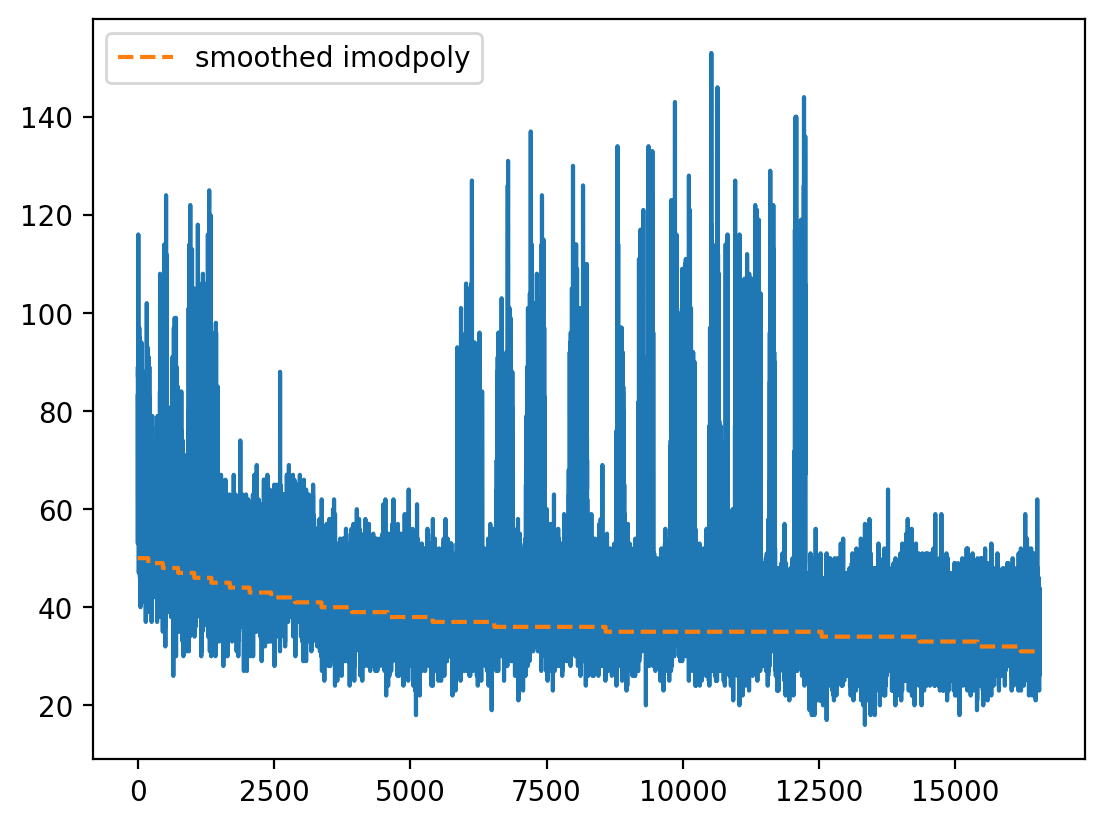

In [126]:
x_data = np.linspace(0, len(detector1), len(detector1))
y_data0 = detector0
y_data1 = detector1

baseline_fitter = Baseline(x_data=x_data)

smoothed_imodpoly0 = baseline_fitter.imodpoly(y_data0, poly_order=3, num_std=0.7)[0]
smoothed_imodpoly1 = baseline_fitter.imodpoly(y_data1, poly_order=3, num_std=0.7)[0]

plt.figure()
plt.plot(y_data1)
#plt.plot(regular_imodpoly, label='imodpoly')
plt.plot(smoothed_imodpoly1, '--', label='smoothed imodpoly')
#plt.plot(baseline, ':', label='true baseline')
plt.legend()

plt.show()

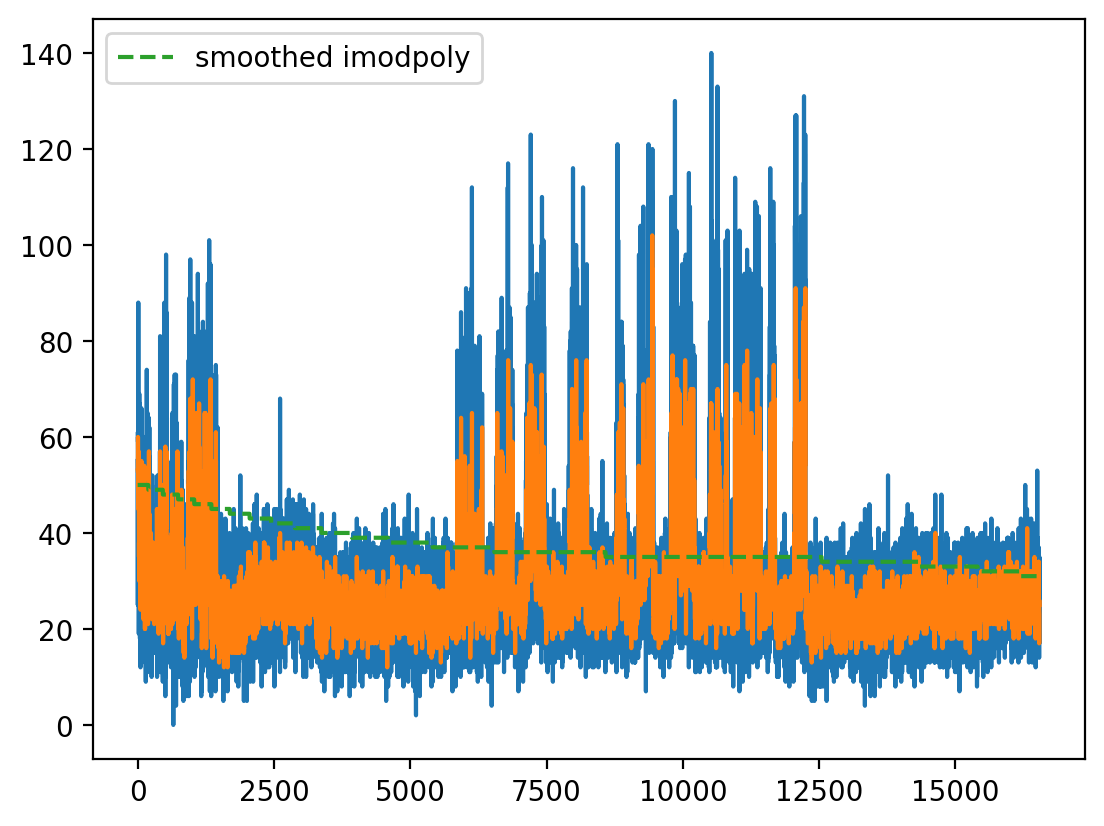

In [127]:
# Subtract the baseline from the data
y_data_corrected0 = y_data0 - smoothed_imodpoly0
y_data_corrected1 = y_data1 - smoothed_imodpoly1

# shift the data to positive values
y_data_corrected0 = y_data_corrected0 + np.abs(np.min(y_data_corrected0))
y_data_corrected1 = y_data_corrected1 + np.abs(np.min(y_data_corrected1))

# smooth the data with a rolling median filter
y_data_smoothed = pd.Series(y_data_corrected1).rolling(5, center=True).median()

# Plot the corrected data
plt.figure()
plt.plot(y_data_corrected1)
plt.plot(y_data_smoothed, '-')
plt.plot(smoothed_imodpoly1, '--', label='smoothed imodpoly')
plt.legend()

plt.show()


In [128]:
# Create a pandas dataframe
df0 = pd.DataFrame({'detector0': y_data_corrected0})
df1 = pd.DataFrame({'detector1': y_data_corrected1})
df_sum = pd.DataFrame({'detector_sum': y_data_corrected0 + y_data_corrected1})

# save the dataframe to a csv file without the index
df0.to_csv('timetrace0.csv', index=False, header=False)
df1.to_csv('timetrace1.csv', index=False, header=False)
df_sum.to_csv('timetrace_sum.csv', index=False, header=False)

df0.head()
df1.head()
df_sum.head()

detector_sum
0           125
1           158
2            94
3           109
4           145

         0
0       70
1      105
2       67
3       84
4       84
...    ...
16537   26
16538   24
16539   42
16540   33
16541   29

[16542 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>
       detector0
0             70
1            105
2             67
3             84
4             84
...          ...
16537         26
16538         24
16539         42
16540         33
16541         29

[16542 rows x 1 columns]


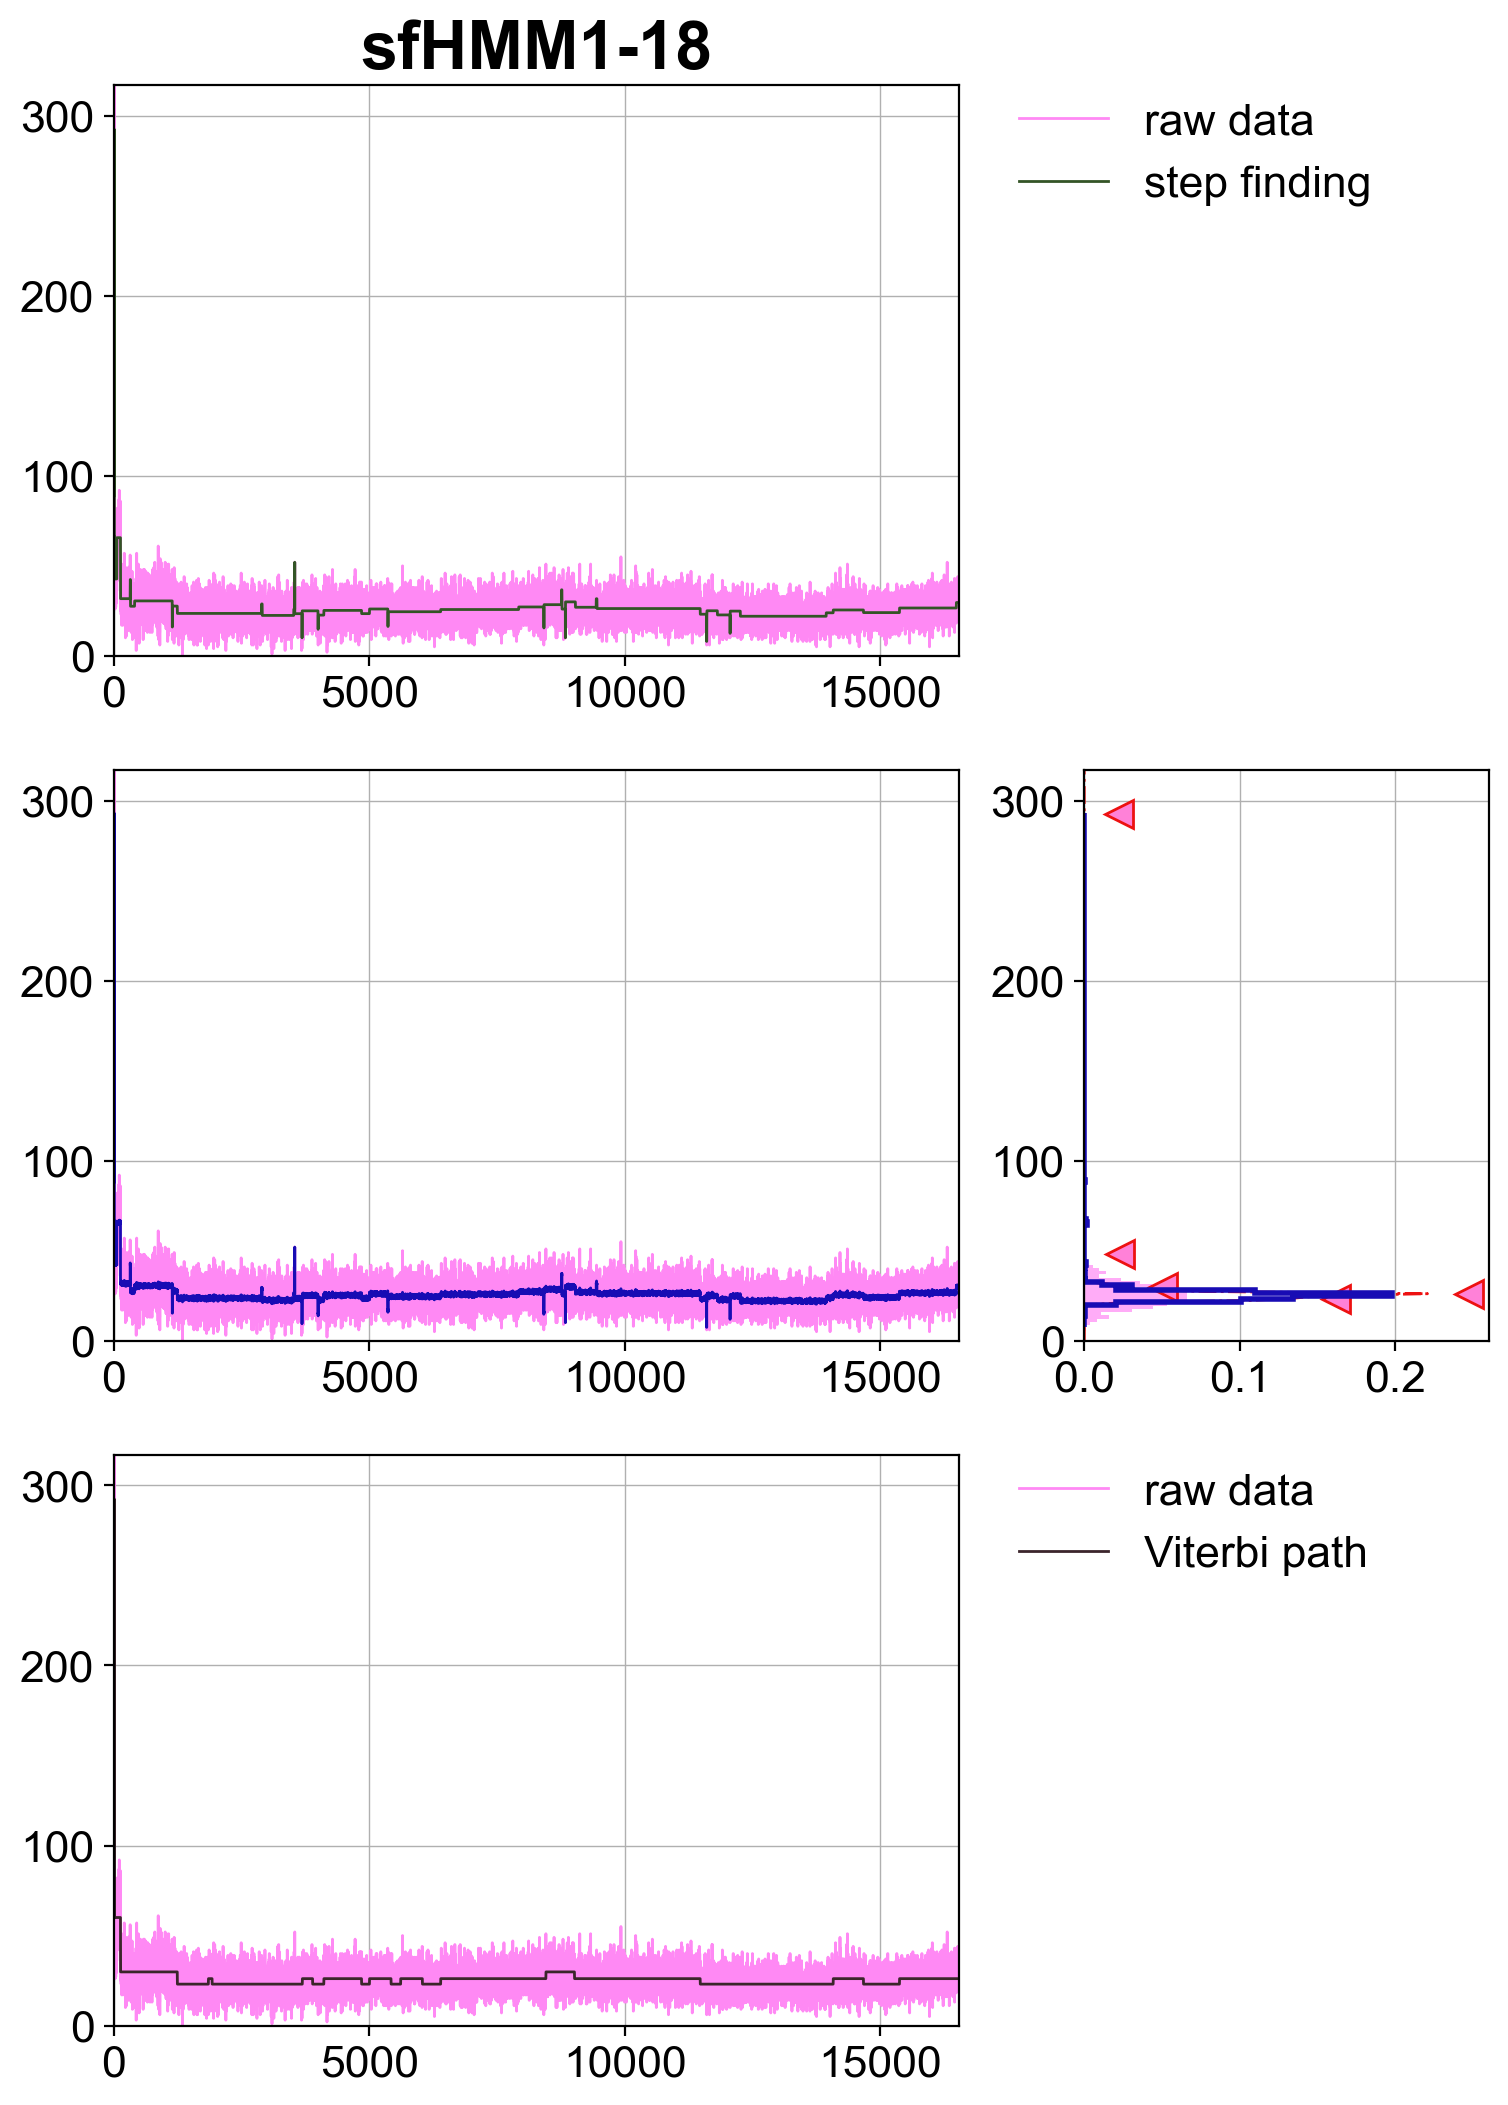

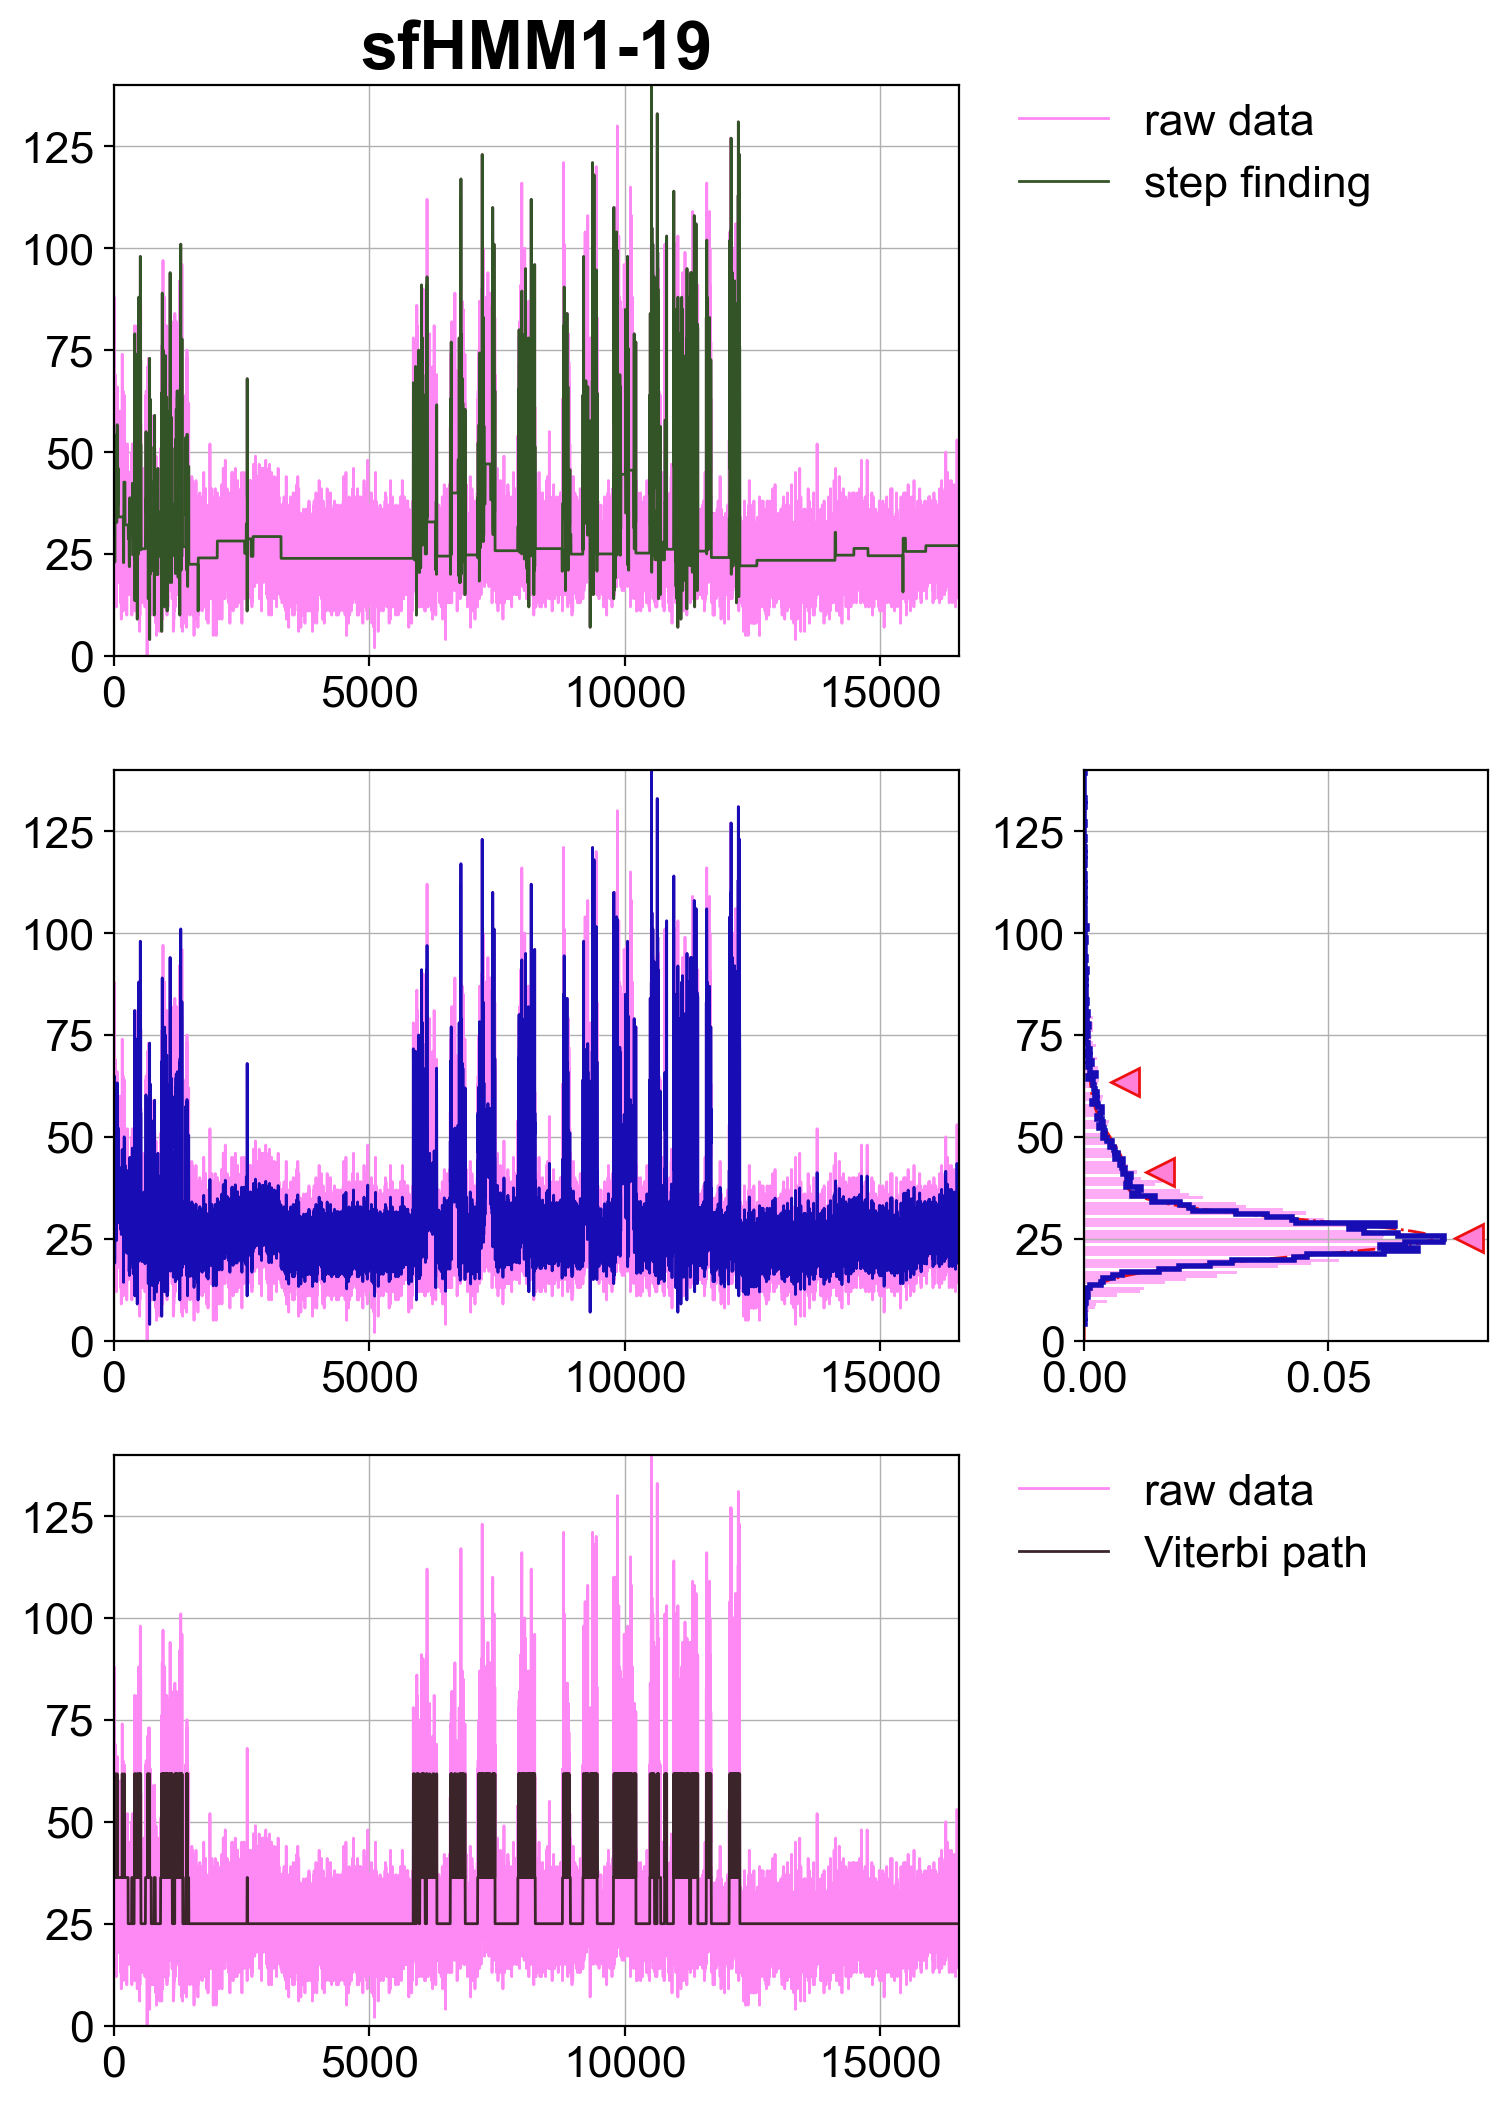

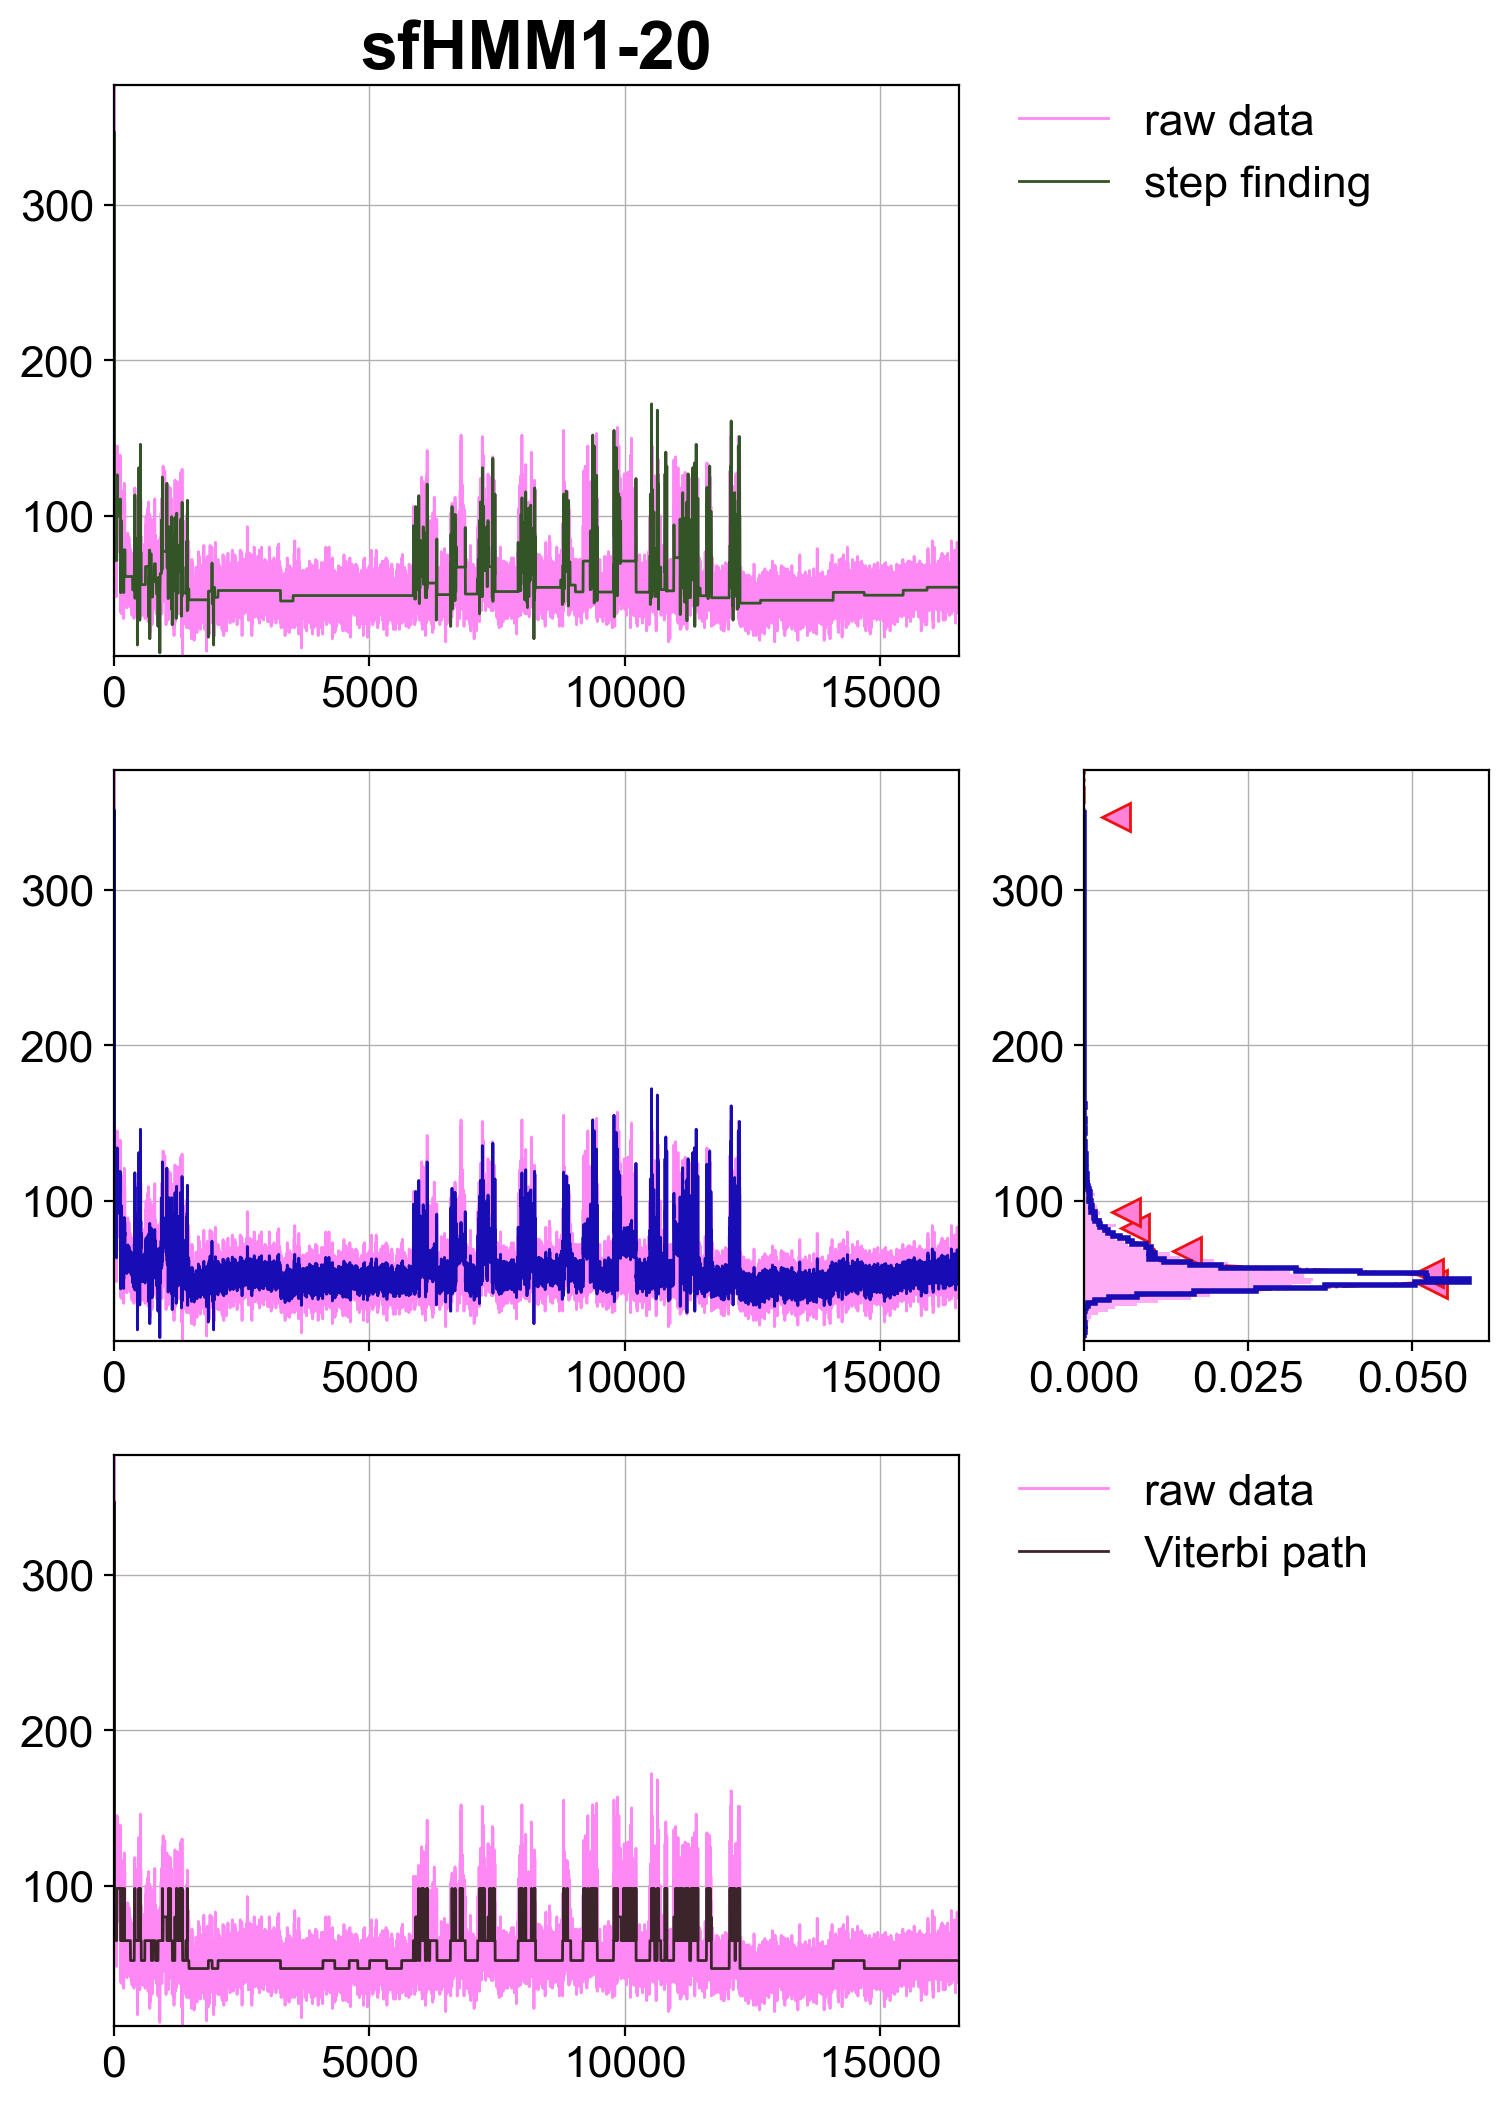

In [145]:
csv_path0 = '/Users/kappel/Documents/Programming/python-projects/s04-data-analysis/on-off-times/timetrace0.csv'
csv_path1 = '/Users/kappel/Documents/Programming/python-projects/s04-data-analysis/on-off-times/timetrace1.csv'
csv_path_sum = '/Users/kappel/Documents/Programming/python-projects/s04-data-analysis/on-off-times/timetrace_sum.csv'
data0 = pd.read_csv(csv_path0, header=None, index_col=False)
data1 = pd.read_csv(csv_path1, header=None, index_col=False)
data_sum = pd.read_csv(csv_path_sum, header=None, index_col=False)

print(data0)
print(type(data0))
print(df0)

# delete datapoints from 2000 inwards
#data = data.drop(data.index[12000:])
sf0 = sfHMM1(df0, krange=(2,5), model='p').run_all()
sf1 = sfHMM1(data1, krange=(2,5), model='p').run_all()
sf_sum = sfHMM1(data_sum, krange=(2,6), model='p').run_all()

In [130]:
'''plt.plot(sf0.data_raw, color="lightgray")
plt.plot(sf0.data_fil, color="gray")
plt.plot(sf0.step.fit, color="gold")
plt.plot(sf0.viterbi, color="red")
plt.legend(["raw data", "filtered data", "step fit", "viterbi"])
plt.xlim(6000, 6350)
plt.show()'''

# create the same plot with bokeh
p = figure(width=1500, height=600, title="on-off-sfHMM")
#p.line(x=np.arange(len(sf0.data_raw)), y=sf0.data_raw, color="lightgray", legend_label="raw data0")
p.line(x=np.arange(len(sf1.data_raw)), y=sf1.data_raw, color="gray", legend_label="raw data1")
#p.line(x=np.arange(len(sf0.data_fil)), y=sf0.data_fil, color="gray", legend_label="filtered data")
#p.line(x=np.arange(len(sf0.step.fit)), y=sf0.step.fit, color="gold", legend_label="step fit")
#p.line(x=np.arange(len(sf0.viterbi)), y=sf0.viterbi, color="red", legend_label="viterbi0", line_width=2)
p.line(x=np.arange(len(sf1.viterbi)), y=sf1.viterbi, color="green", legend_label="viterbi1",line_width=2)
p.legend.location = "top_left"
show(p)

In [131]:
# create the same plot with bokeh
p = figure(width=1500, height=600, title="on-off-sfHMM--SUM")
p.line(x=np.arange(len(sf_sum.data_raw)), y=sf_sum.data_raw, color="lightgray", legend_label="raw data0")
p.line(x=np.arange(len(sf_sum.viterbi)), y=sf_sum.viterbi, color="purple", legend_label="viterbi0", line_width=2)
p.legend.location = "top_left"
show(p)

In [132]:
# print unique values of the viterbi path
print(np.unique(sf0.viterbi))

# calculate step sizes
first_step_size0 = np.unique(sf0.viterbi)[1] - np.unique(sf0.viterbi)[0]
second_step_size0 = np.unique(sf0.viterbi)[2] - np.unique(sf0.viterbi)[1]
print(first_step_size0)
print(second_step_size0)

print(np.unique(sf1.viterbi))

# calculate step sizes
first_step_size1 = np.unique(sf1.viterbi)[1] - np.unique(sf1.viterbi)[0]
second_step_size1 = np.unique(sf1.viterbi)[2] - np.unique(sf1.viterbi)[1]
print(first_step_size1)
print(second_step_size1)



[ 23.00920826  26.0556093   29.79807534  60.00752356 292.5       ]
3.046401041177397
3.7424660410311503
[24.98681566 36.31211881 61.75645174]
11.32530315285575
25.44433292944685


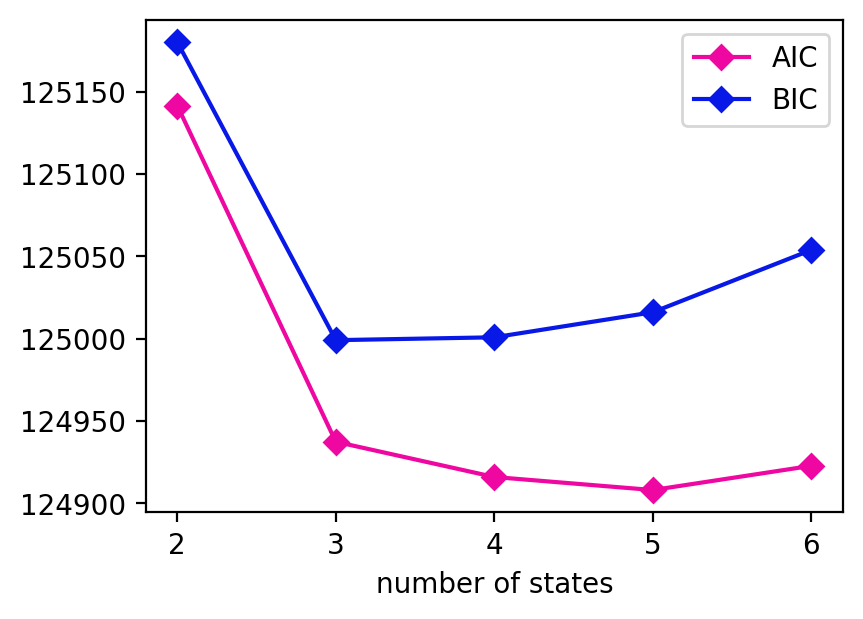

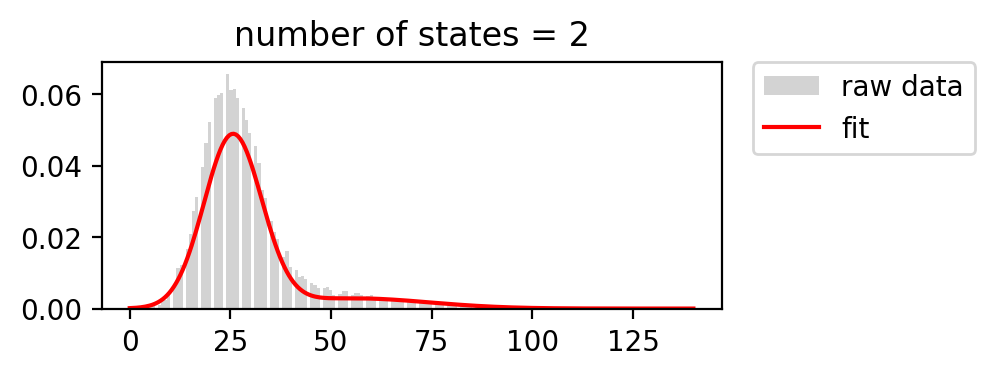

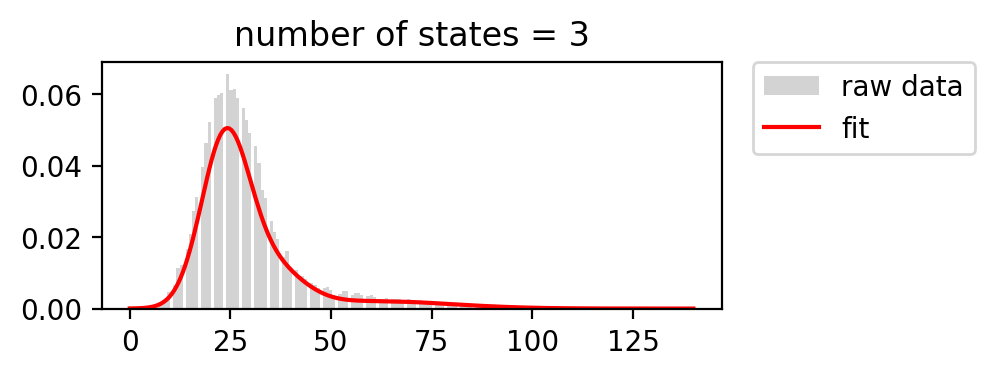

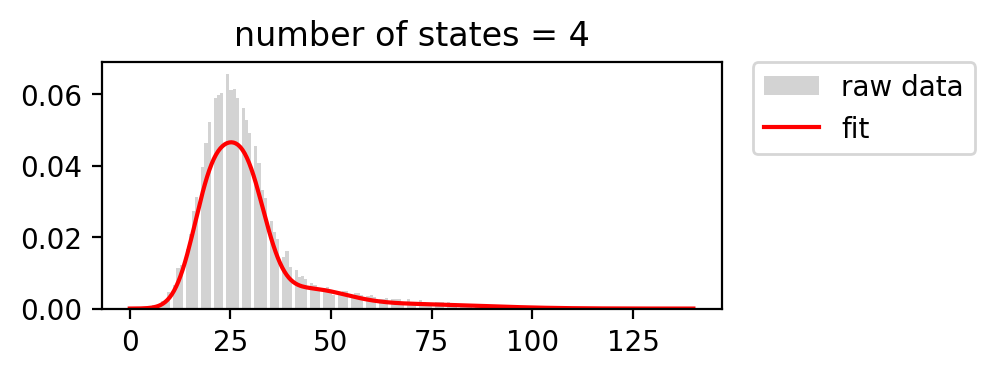

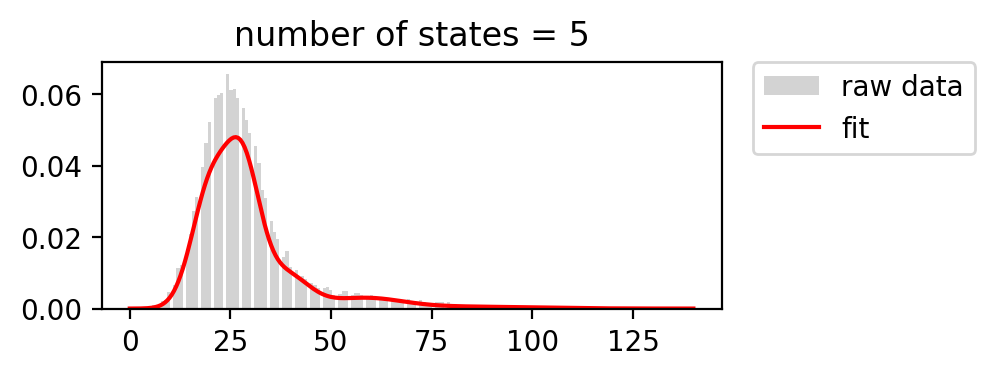

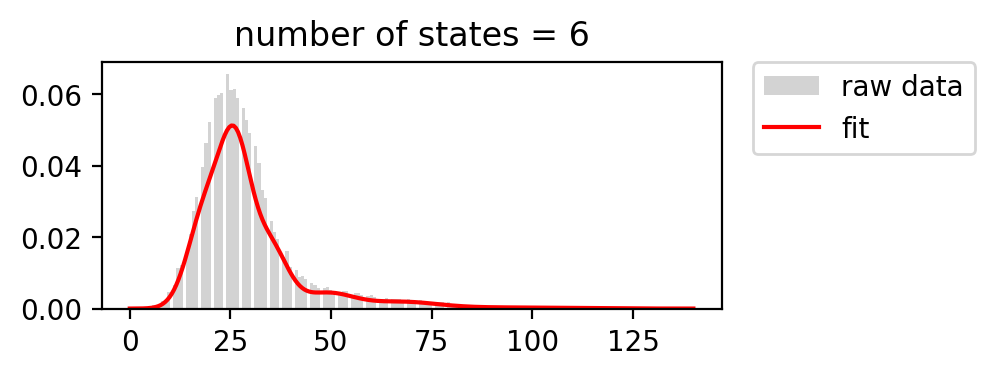

In [133]:
data = pd.read_csv(csv_path1, header=None, index_col=False)

from sfHMM.gmm import GMMs
gmms = GMMs(data, krange=(2, 6))
gmms.fit()
gmms.show_aic_bic()
gmms.plot_all()

In [134]:
# get the best model that minimizes BIC
gmm_optimal = gmms.get_optimal(criterion="bic")
print(gmm_optimal)
print("means =\n", gmm_optimal.means_)

GMM1(n_components=3)
means =
 [[23.6602063 ]
 [34.76265594]
 [61.07964294]]


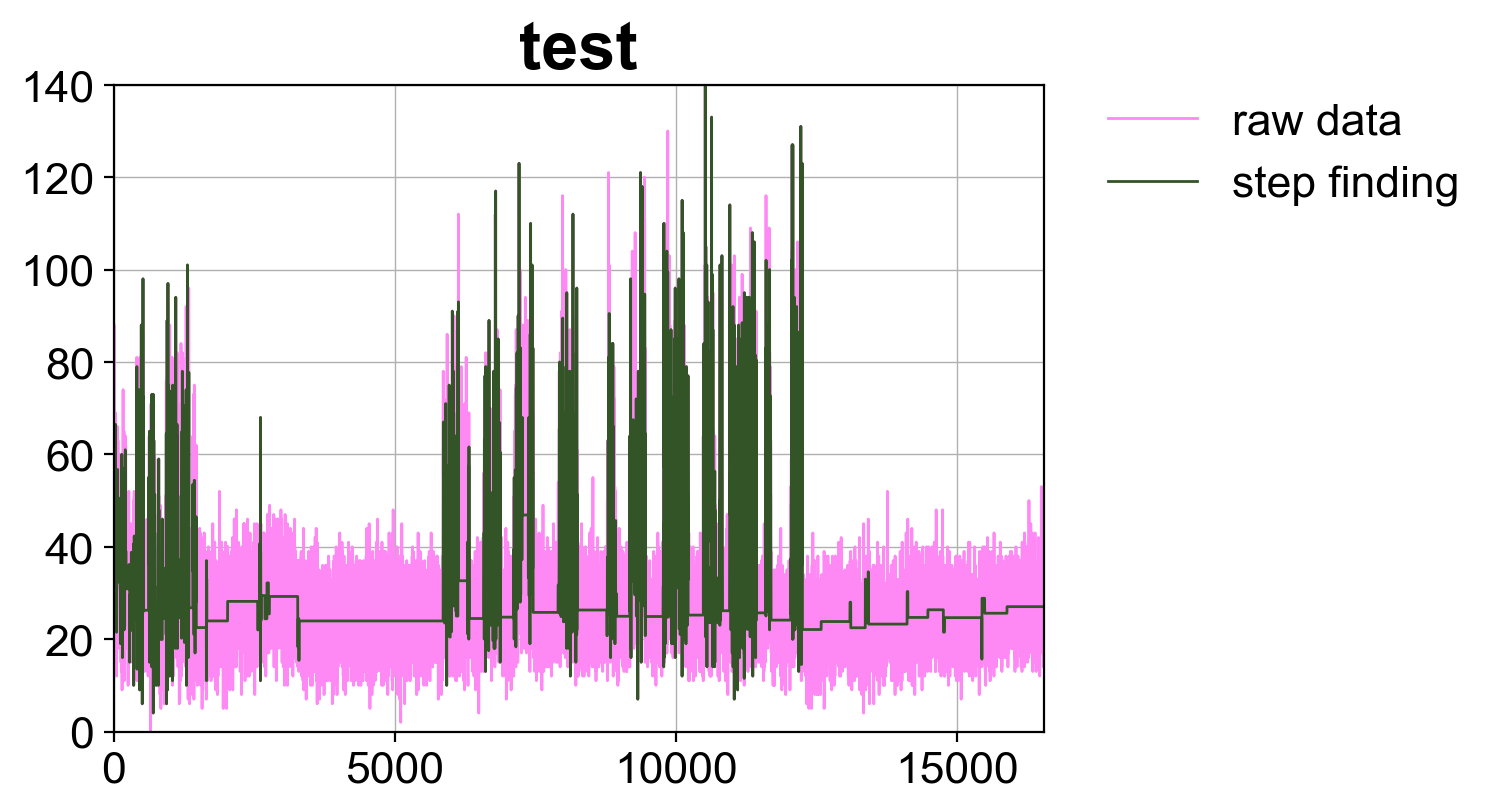

In [135]:
sf = sfHMM1(data, psf=0.03, name="test", model='p')

# 1. step finding
sf.step_finding()
sf.plot()

In [136]:
# 2. denoising
sf.denoising()

sfHMM1(model='PoissonStep', psf=0.03, sg0=3.9000000000000004)

3


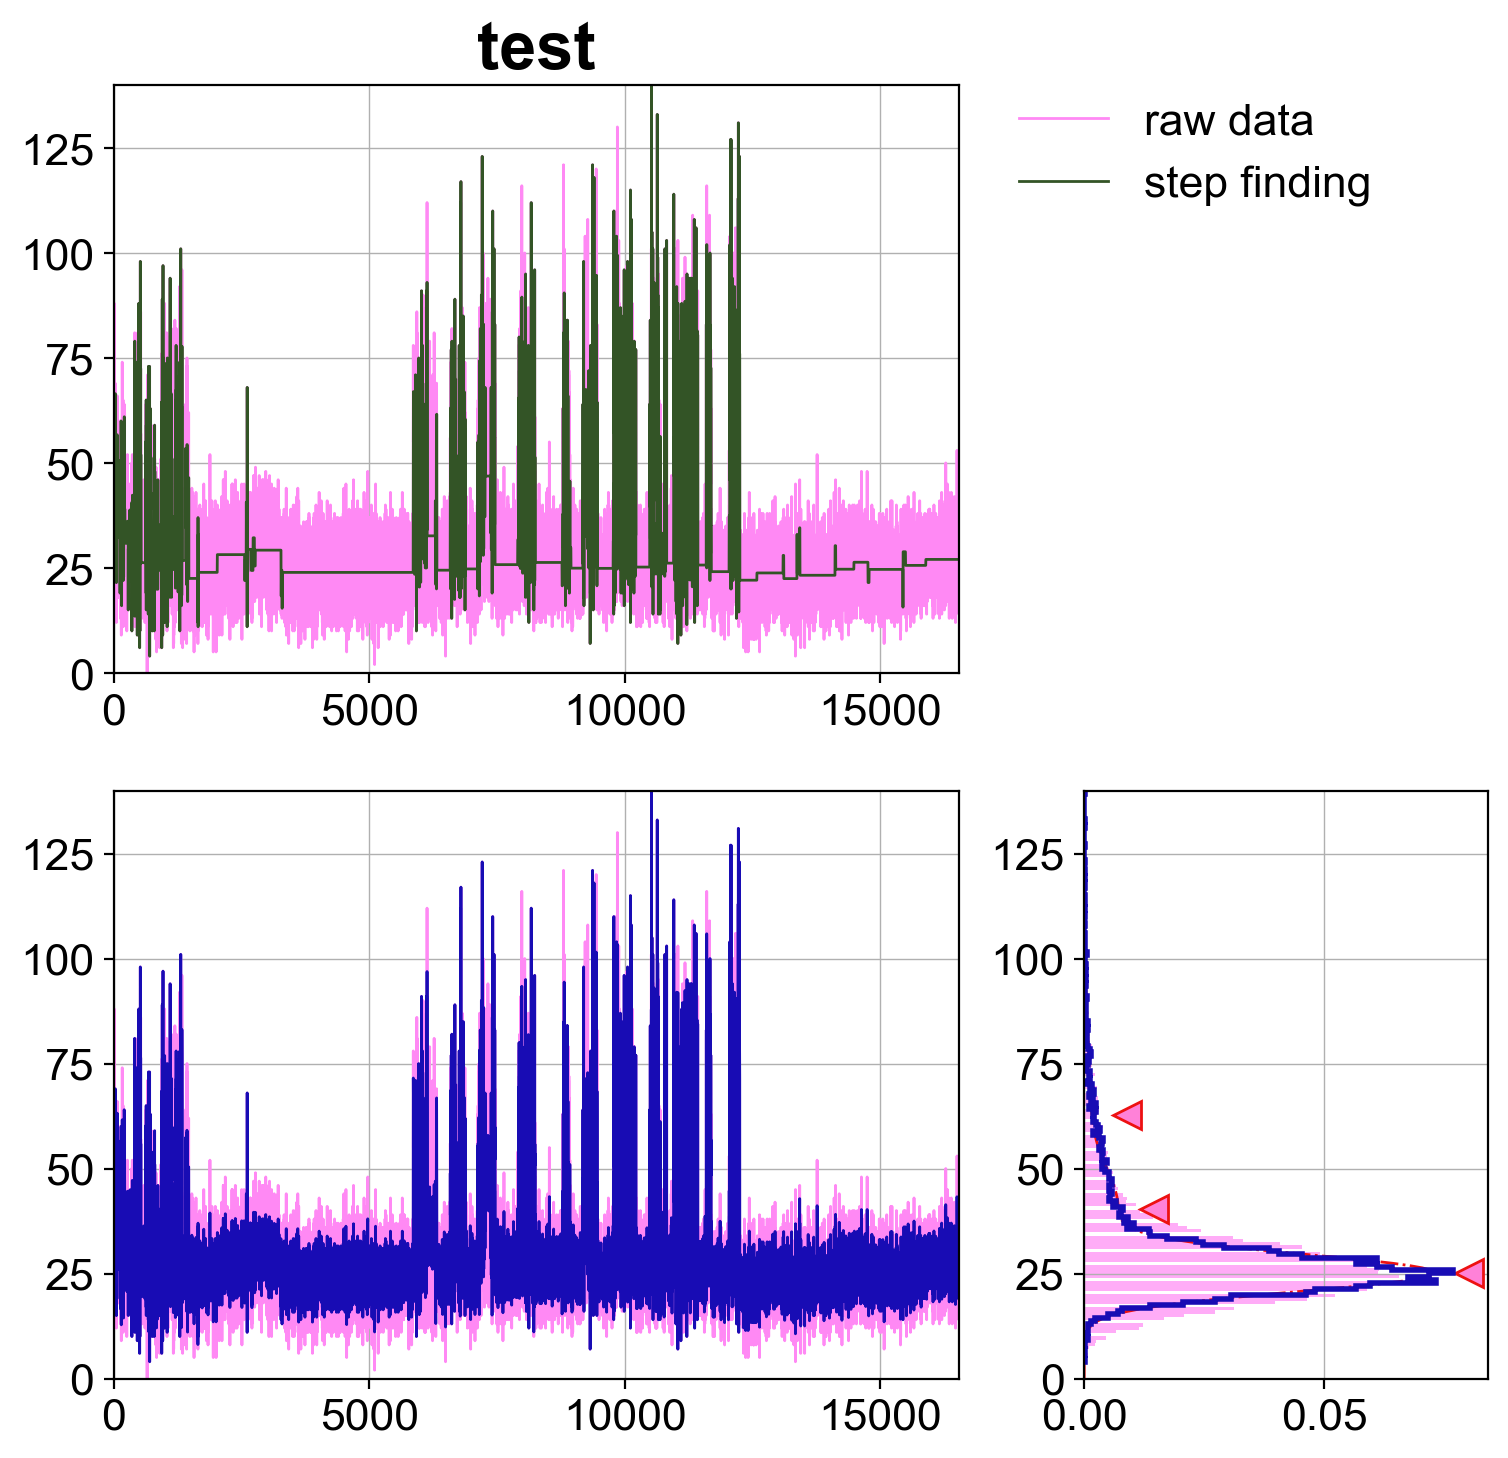

In [137]:
# 3. gmmfit
sf.gmmfit(n_init=2, method="bic")
print(sf.n_components)
sf.plot()

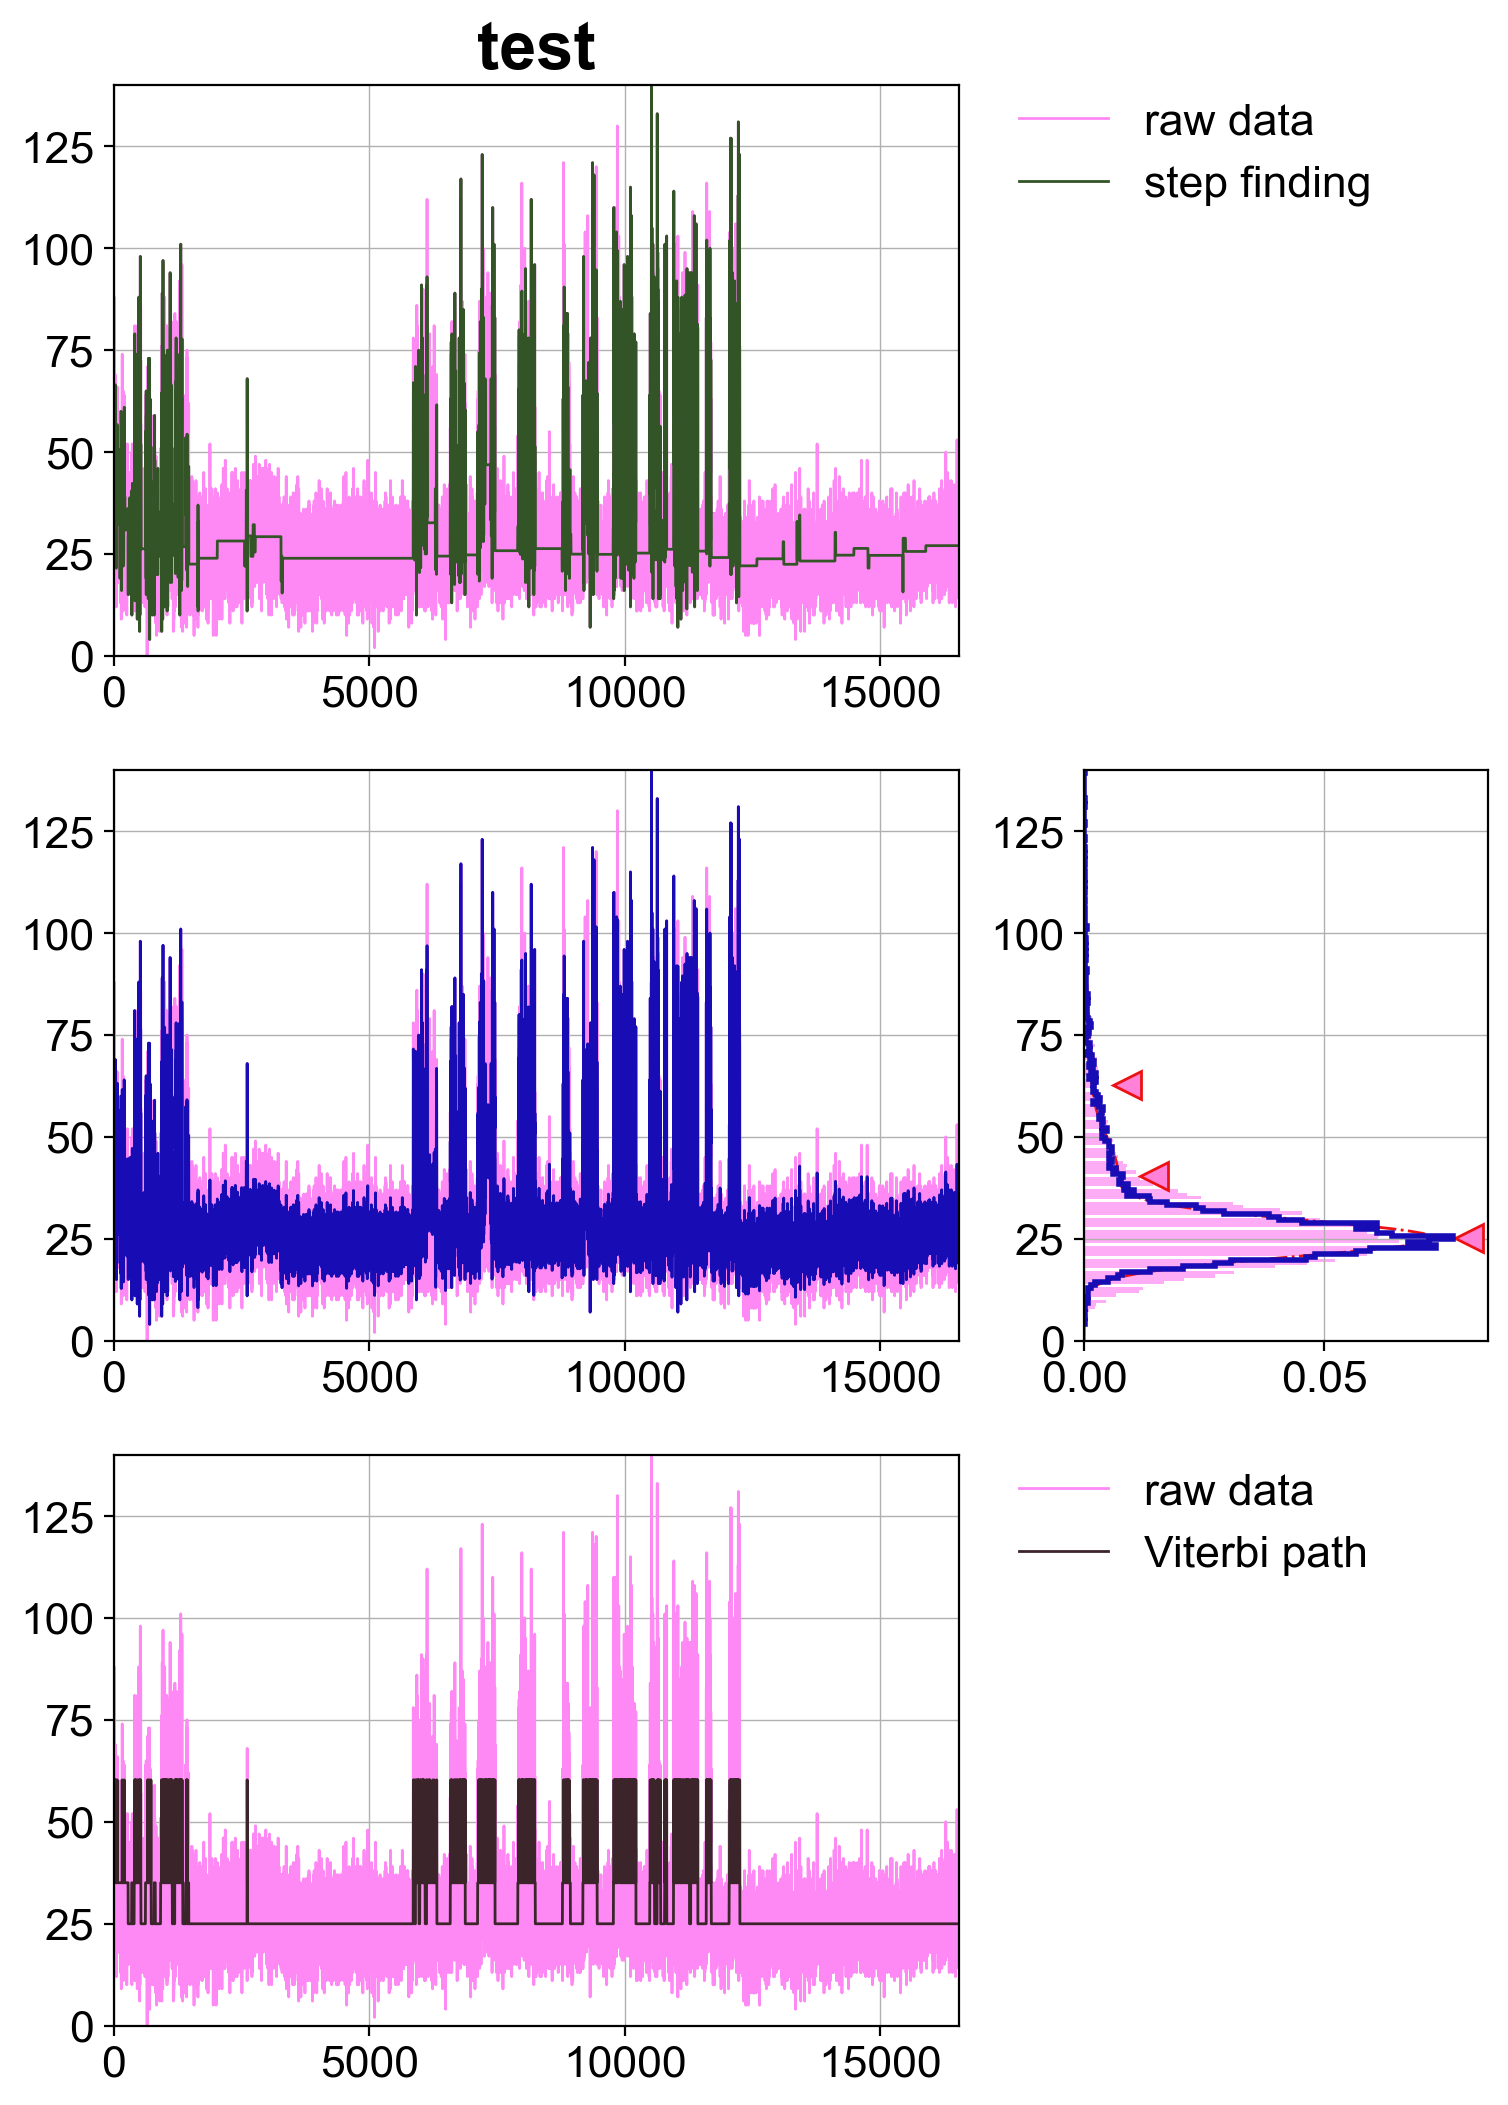

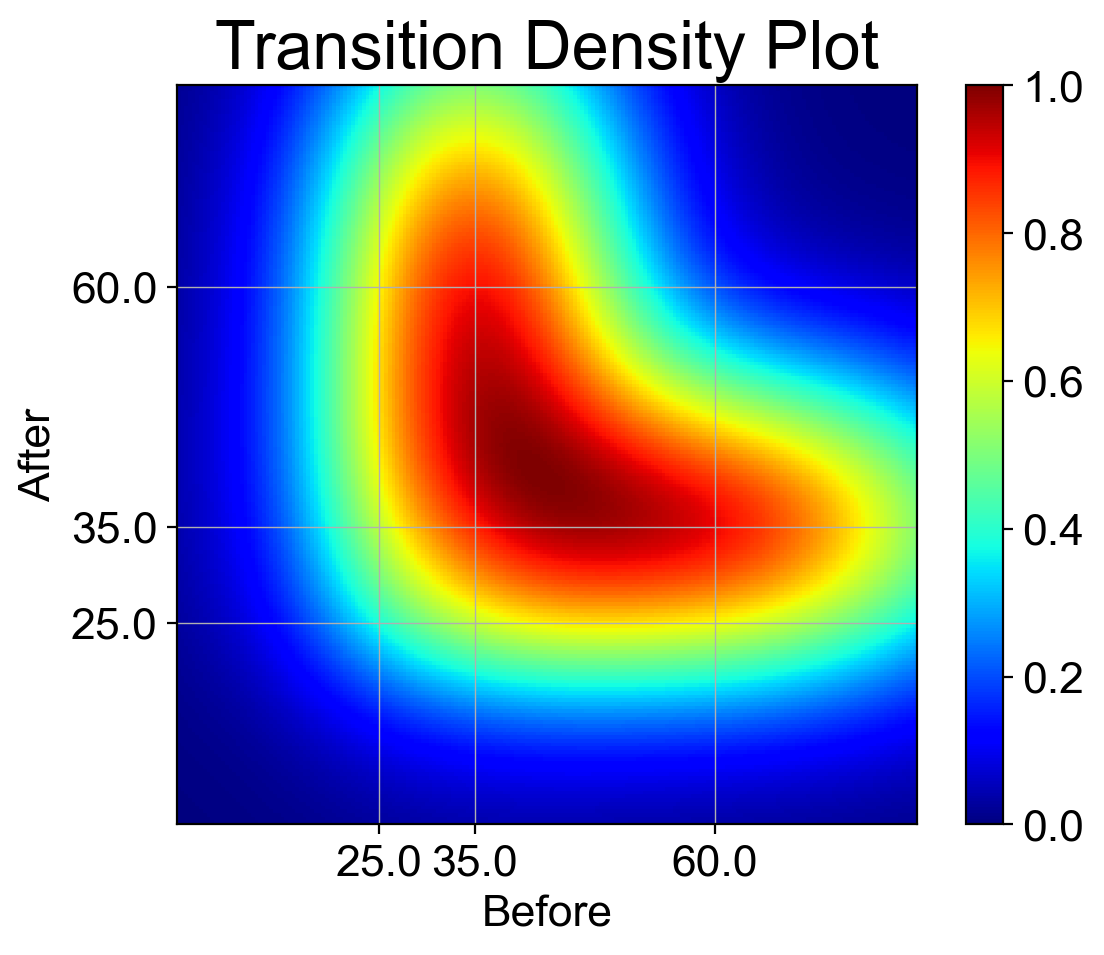

In [138]:
# 4. hmmfit
sf.hmmfit()
sf.plot()
sf.tdp()

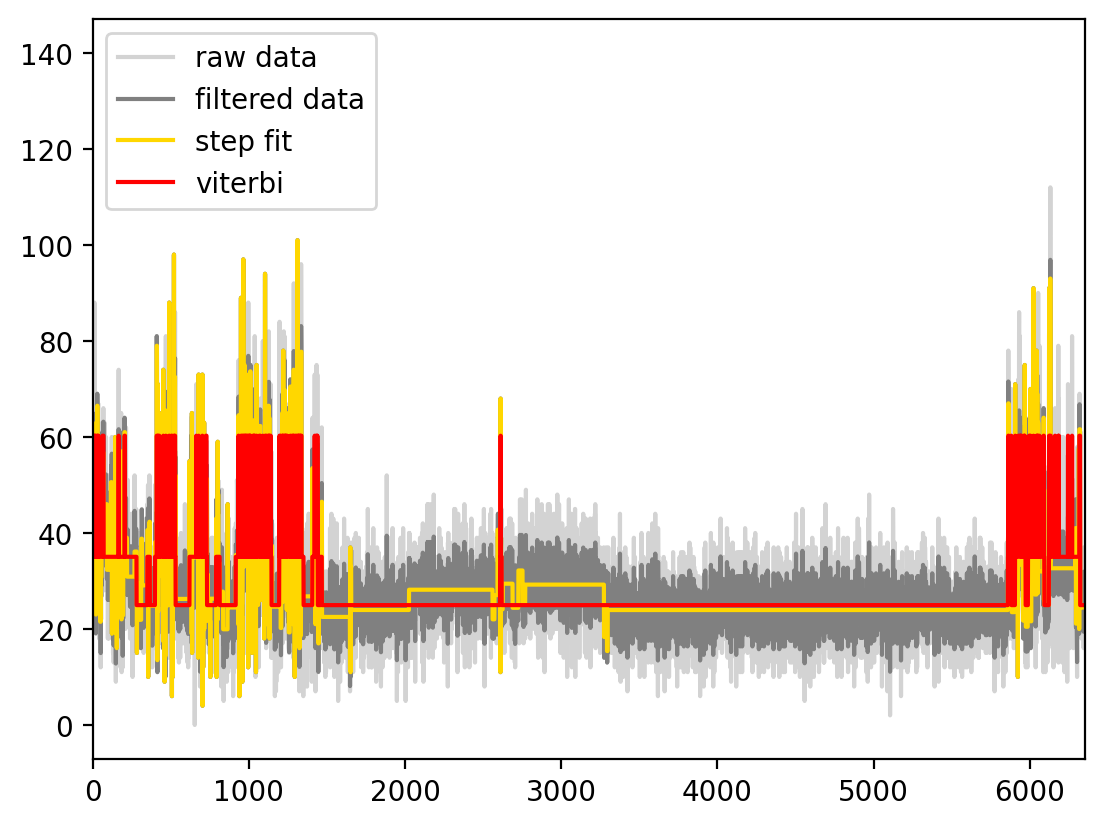

In [139]:
plt.plot(sf.data_raw, color="lightgray")
plt.plot(sf.data_fil, color="gray")
plt.plot(sf.step.fit, color="gold")
plt.plot(sf.viterbi, color="red")
plt.legend(["raw data", "filtered data", "step fit", "viterbi"])
plt.xlim(0, 6350)
plt.show()



sf.sg0 =
 3.9000000000000004
sf.n_components =
 3
sf.means_ =
 [[24.96556968]
 [35.03098932]
 [60.26112917]]
sf.states =
 [1 1 1 ... 0 0 0]


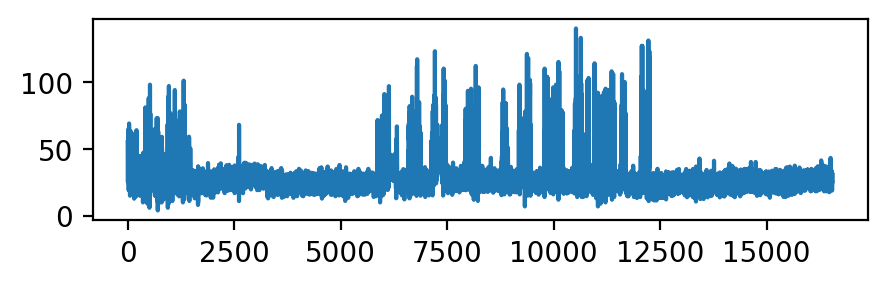

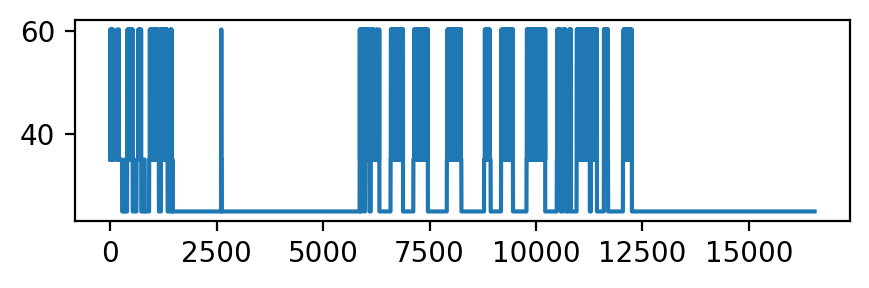

In [140]:
print("sf.sg0 =\n", sf.sg0)
print("sf.n_components =\n", sf.n_components)
print("sf.means_ =\n", sf.means_)
print("sf.states =\n", sf.states)
plt.figure(figsize=(5, 1.3))
plt.plot(sf.data_fil)
plt.show()
plt.figure(figsize=(5, 1.3))
plt.plot(sf.viterbi)
plt.show()

In [141]:
# create the same plot with bokeh
p = figure(width=1500, height=600, title="on-off-sfHMM")
p.line(x=np.arange(len(sf.data_raw)), y=sf.data_raw, color="lightgray", legend_label="raw data")
p.line(x=np.arange(len(sf.data_fil)), y=sf.data_fil, color="gray", legend_label="filtered data")
p.line(x=np.arange(len(sf.step.fit)), y=sf.step.fit, color="gold", legend_label="step fit")
p.line(x=np.arange(len(sf.viterbi)), y=sf.viterbi, color="red", legend_label="viterbi", line_width=2)
p.legend.location = "top_left"
show(p)

17.264865345289422


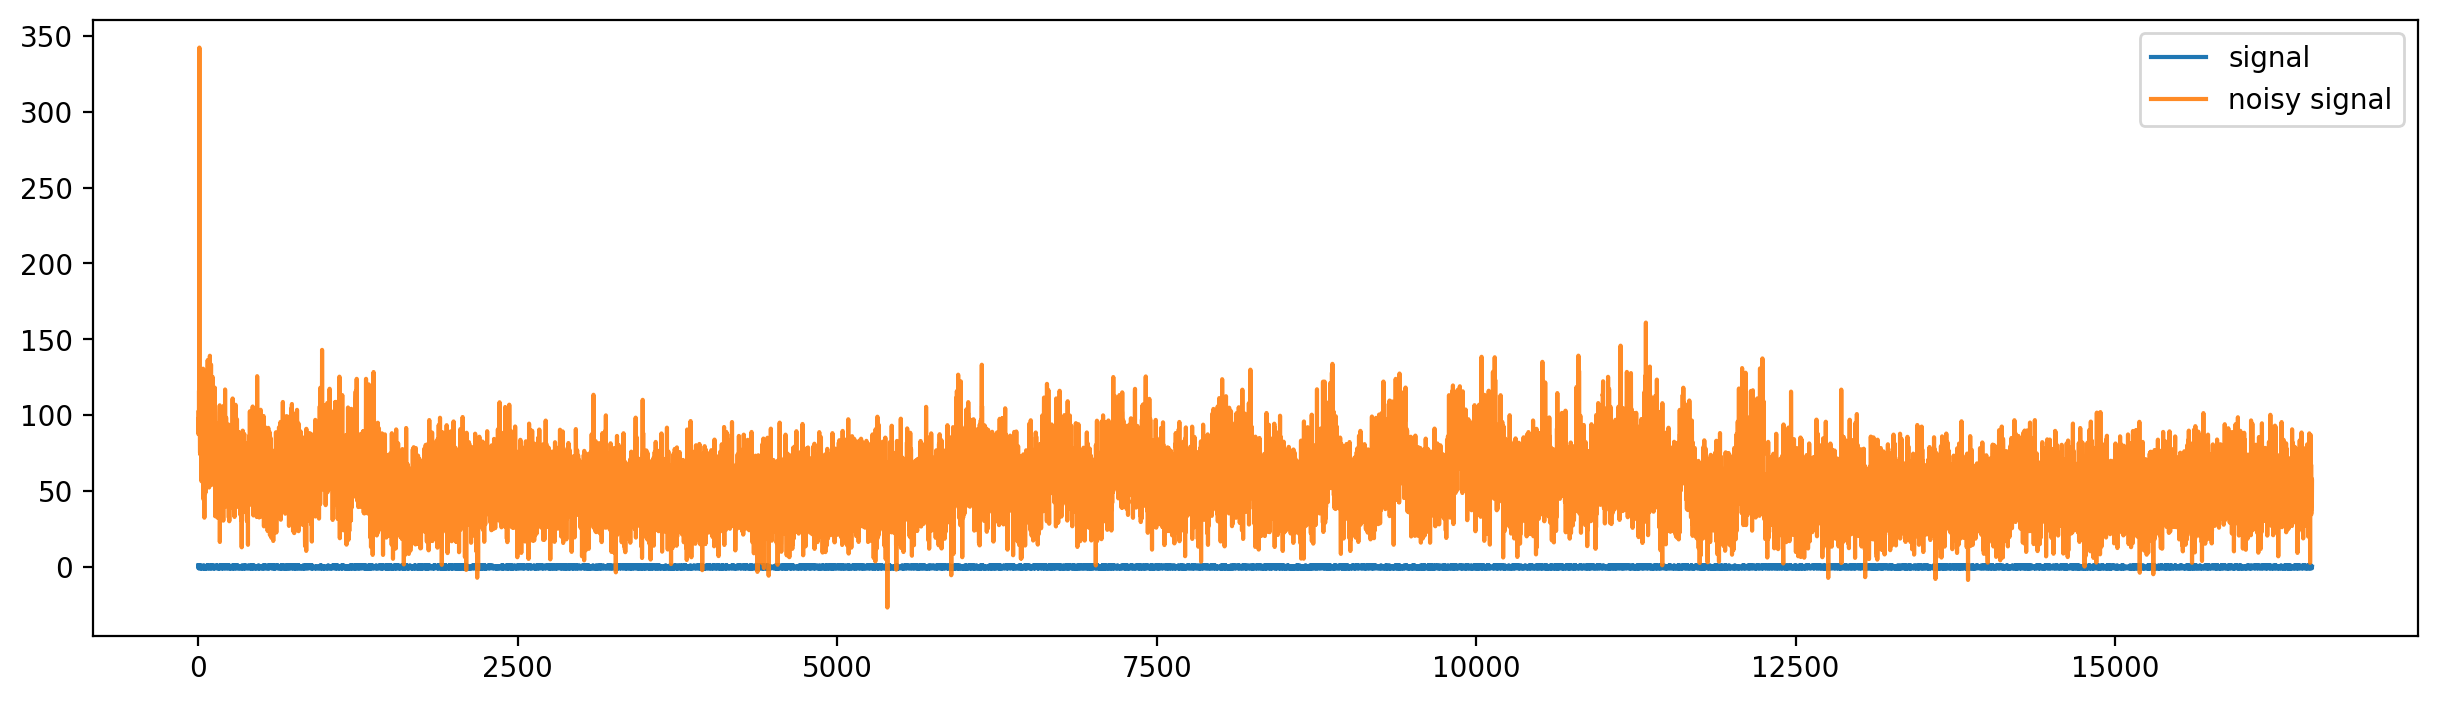

17.264865345289422


In [142]:
import numpy as np
import matplotlib.pyplot as plt

# define the transition probabilities between different states
trans_probs = np.array([[0.1, 0.4, 0.5], [0.1, 0.5, 0.4], [0.1, 0.6, 0.3]])

# define the initial state
init_state = 0

# simulate the Markov model to generate a sequence of states
num_steps = len(sf_sum.viterbi)
states = np.zeros(num_steps, dtype=int)
states[0] = init_state
for i in range(1, num_steps):
    states[i] = np.random.choice([0, 1, 2], p=trans_probs[states[i-1]])

# convert the sequence of states to a signal
signal = np.where(states == 0, 1, np.where(states == 1, 0, -1))

# get noise from raw data
noise_std = np.std(sf_sum.data_raw)
print(noise_std)

# add noise to the signal
mean = 0
std = noise_std
noise = np.random.normal(mean, std, num_steps)
signal_noisy = sf_sum.viterbi + noise

# plot the results
fig = plt.figure(figsize=(15, 4))
plt.plot(signal, label='signal')
plt.plot(signal_noisy, label='noisy signal', alpha=0.9)
plt.legend()
plt.show()

# create the same plot with bokeh
p = figure(width=1500, height=600, title="on-off-sfHMM")
p.line(x=np.arange(len(sf_sum.viterbi)), y=signal, color="lightgray", legend_label="signal")
p.line(x=np.arange(len(signal_noisy)), y=signal_noisy, color="gray", legend_label="noisy signal")
p.line(x=np.arange(len(sf_sum.data_raw)), y=sf_sum.data_raw, color="red", legend_label="data raw", line_width=2, alpha=0.5)
p.legend.location = "top_left"
show(p)

noise_std = np.std(sf_sum.data_raw)
print(noise_std)

In [143]:
from scipy.stats import pearsonr

# compute the Pearson correlation coefficient
corr, _ = pearsonr(sf_sum.data_raw, signal_noisy)
print('Pearson correlation coefficient:', corr)

# compute the mean squared error
mse = np.mean((sf_sum.data_raw - signal_noisy)**2)

# compute the root mean squared error
rmse = np.sqrt(mse)
print('Mean squared error:', rmse)

# compute the signal-to-noise ratio
snr = np.mean(sf_sum.data_raw) / noise_std
print('Signal-to-noise ratio:', snr)

Pearson correlation coefficient: 0.3811352196879614
Mean squared error: 21.064616129278615
Signal-to-noise ratio: 3.19993596488765
